# Model tuning and comparison

In this notebook, we will investigate different models and transformers to see which one performs better and what are the best hyperparameters. <br>
<br>For estimator, we will use:
- Logistic Regression
- KNN 
- Naive Bayes

For transformers, the following approaches are used:
- `CountVectorizer`
- `TfidfVectorizer`

Our analysis in starts by using `CountVectorizer` as our initial transformer. Various models will be used on this data and upon finding the best performing model, we will use that model to test against `TfidfVectorizer` as well to see which one performs better. 


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
from nltk.sentiment.vader import SentimentIntensityAnalyzer # for sentiment analyzer
#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


## Data preparation and train/test split

Similar to the previous section, we will be preparing our data by dropping unnecessary columns, mixing the title and text data and also adding sentiment and word count columns (this data will be used at the end).

In [2]:
# import data
df = pd.read_csv('./../dataset/offmychestrelationship_advice.csv')
# drop unnecessary columns
df = df.drop(columns=['listingid', 'created', 'url', 'media'])
# mix text and title columns
df['text'] = df.apply(lambda x: x['text'] + x['title'], axis=1)
df = df.drop(columns=['title'])
# convert subreddit names to numbers offmychest = 0, relationship_advice = 1
df['subreddit'] = df['subreddit'].map(
                                      {'offmychest': 0, 
                                       'relationship_advice': 1})
# add a new column for the word count in the text
df['word_count'] = df['text'].apply(lambda x: 
                                    len(re.findall(r'(?u)\b\w\w+\b', x)))
# add a new column for the sentiment of the text in each listing
sent = SentimentIntensityAnalyzer()
df['sentiment'] = df.apply(lambda x: 
                           sent.polarity_scores(x['text'])['compound'],
                           axis=1)
df.head(2)

,text,subreddit,word_count,sentiment
0,I had a few toxic relationships as a teenage a...,0,186,0.9515
1,"TLDR is, essentially, the title.\n\nFor a litt...",1,494,0.8858


In [3]:
X = df[['text', 'word_count', 'sentiment']]
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)
X_train = pd.DataFrame(X_train, columns=['text', 'word_count', 'sentiment'])
X_test = pd.DataFrame(X_test, columns=['text', 'word_count', 'sentiment'])

## Logistic Regression with CountVectorizer

For this section, we will use the model prepared from benchmarking notebook in which we optimized the Logistic Regression parameters with Gridseach and found the best performance. 

In [12]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_logr = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 2)],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'cvec__min_df': [2, 4],
    'cvec__max_features': [3000],
    'logr__C': [0.02, 0.05, 0.07, 0.1, 0.2],
    'logr__penalty': ['l2'], 
}

gs_cvec_logr = GridSearchCV(pipe_cvec_logr,
                 param_grid=params_cvec_logr,
                 n_jobs=-1,
                 cv=3,
                 verbose=2)

gs_cvec_logr.fit(Z_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


c:\Users\masou\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [1.0, 0.8, 0.5],
                         'cvec__max_features': [3000], 'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'logr__C': [0.02, 0.05, 0.07, 0.1, 0.2],
                         'logr__penalty': ['l2']},
             verbose=2)

In [15]:
print('============= LogReg =============')
print(f'best cv score: {gs_cvec_logr.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_logr.best_params_.items()];
print('=============')
pred = gs_cvec_logr.predict(Z_test)

print(f'train score: {gs_cvec_logr.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_logr.score(Z_test, y_test)}')

print('=============')
#pd.DataFrame(gs_cvec_logr.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

best cv score: 0.8703431372549021
best params:
cvec__max_df: 1.0
cvec__max_features: 3000
cvec__min_df: 4
cvec__ngram_range: (1, 2)
cvec__stop_words: english
logr__C: 0.07
logr__penalty: l2
train score: 0.9609068627450981
test score: 0.8682018618324351


## KNN with CountVectorizer

In this section, we will see how KNN will perform in classifying our data.

In [23]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_knn = {
    'cvec__stop_words': [None] ,# 'english'],
    'cvec__ngram_range': [(1, 2)],
    'cvec__max_df': [0.95], # 0.8, 0.5],
#    'cvec__min_df': [2, 4],
    'cvec__max_features': [300, 500],
    'knn__n_neighbors': list(range(8, 25, 2))
}

gs_cvec_knn = GridSearchCV(pipe_cvec_knn,
                 param_grid=params_cvec_knn,
                 n_jobs=-1,
                 cv=3,
                 verbose=1)

gs_cvec_knn.fit(Z_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [300, 500],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None],
                         'knn__n_neighbors': [8, 10, 12, 14, 16, 18, 20, 22,
                                              24]},
             verbose=1)

In [25]:
print('============= KNN =============')
print(f'best cv score: {gs_cvec_knn.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_knn.best_params_.items()];
print('=============')
pred = gs_cvec_knn.predict(Z_test)

print(f'train score: {gs_cvec_knn.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_knn.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_cvec_knn.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= KNN =============
best cv score: 0.7659313725490197
best params:
cvec__max_df: 0.95
cvec__max_features: 300
cvec__ngram_range: (1, 2)
cvec__stop_words: None
knn__n_neighbors: 16
train score: 0.7888480392156862
test score: 0.7569818716315532


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__ngram_range,param_cvec__stop_words,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,8.984113,0.023421,7.313039,0.065151,0.95,300,"(1, 2)",None,16,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.761765,0.764338,0.771691,0.765931,0.004206,1
5,10.833248,1.074074,7.749825,0.297555,0.95,300,"(1, 2)",None,18,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.759559,0.764706,0.771324,0.765196,0.004815,2
8,11.392786,0.114010,7.875746,0.442808,0.95,300,"(1, 2)",None,24,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.762500,0.761765,0.768015,0.764093,0.002789,3
6,11.408488,0.320799,8.272562,0.195014,0.95,300,"(1, 2)",None,20,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.761397,0.761029,0.769485,0.763971,0.003902,4
7,10.892169,0.057670,8.172486,0.095412,0.95,300,"(1, 2)",None,22,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.759559,0.761397,0.770588,0.763848,0.004825,5
3,9.913309,0.064405,6.963654,0.077340,0.95,300,"(1, 2)",None,14,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.763235,0.761029,0.766912,0.763725,0.002426,6
13,11.305877,0.645607,8.151968,0.702207,0.95,500,"(1, 2)",None,16,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.755882,0.769118,0.762132,0.762377,0.005406,7
14,11.389507,0.239440,8.610906,0.314452,0.95,500,"(1, 2)",None,18,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.755882,0.764338,0.762868,0.761029,0.003689,8
15,11.203817,0.211891,8.676597,0.090661,0.95,500,"(1, 2)",None,20,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.758088,0.762132,0.761029,0.760417,0.001707,9
12,10.899371,0.290151,8.941422,0.302061,0.95,500,"(1, 2)",None,14,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.754044,0.764338,0.762132,0.760172,0.004425,10


**Observation:**
- As expected, the KNN performs better when we use fewer number of features. In our case, we case reducing the max number of features to 300-500 would give us the best results. 
- Similar to what we observed with Logistic Regression, when we play with max features in the model, we can see that increasing the max feature does not help with the test/cv score and only helps with the train score, meaning that using features more that a threshold (here 300 to 500) will cause overfitting. 
- Gridsearch analysis shows that using `max_df` of 0.95 gives us the best results.
- Using stopewords are observed to deteriorate model performance so we decided to go with no stop words. 
- Using ngrams (1, 2) improves the scores slightly, so we decided to choose that.
- Best estimators are the ones that use `n_neghbors` in the rang of 10-20 (please see the below graph).


Text(0, 0.5, 'best score')

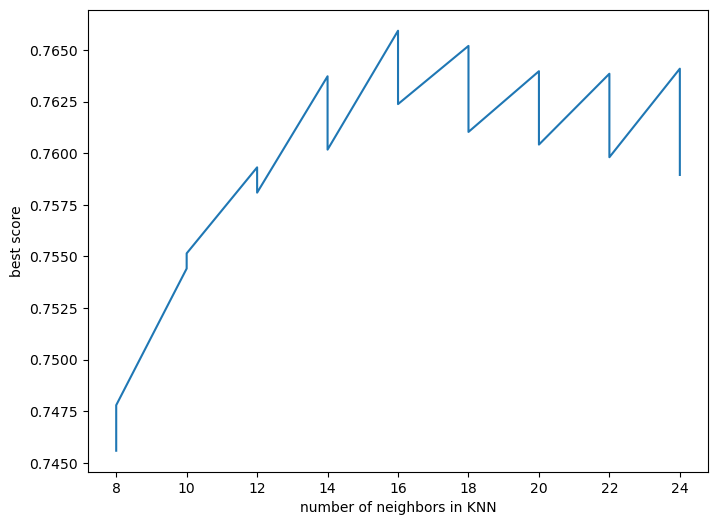

In [32]:
# model performance for different values of n_neghbors
results = pd.DataFrame(gs_cvec_knn.cv_results_)
resutls = results[results['param_cvec__max_features'] ==300]
neighbors = results.sort_values(by='param_knn__n_neighbors', ascending=True)['param_knn__n_neighbors']
scores = results.sort_values(by='param_knn__n_neighbors', ascending=True)['mean_test_score']

plt.figure(figsize=(8,6))
plt.plot(neighbors, scores)
plt.xlabel('number of neighbors in KNN')
plt.ylabel('best score')

## Naive Bayes with CountVectorizer

In this part, we will use multinomial Naive Bayes estimator along with CountVectorizer to see if this model performs any better that the previous estimators.  

In [43]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_mnb = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1)],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'cvec__min_df': [2, 4],
    'cvec__max_features': [3000, 5000],

}

gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb,
                 param_grid=params_cvec_mnb,
                 n_jobs=-1,
                 cv=3,
                 verbose=1)

gs_cvec_mnb.fit(Z_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [1.0, 0.8, 0.5],
                         'cvec__max_features': [3000, 5000],
                         'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [45]:
print('============= MN Naive Bayes =============')
print(f'best cv score: {gs_cvec_mnb.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_mnb.best_params_.items()];
print('=============')
pred = gs_cvec_mnb.predict(Z_test)

print(f'train score: {gs_cvec_mnb.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_mnb.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_cvec_mnb.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= MN Naive Bayes =============
best cv score: 0.8504901960784315
best params:
cvec__max_df: 1.0
cvec__max_features: 5000
cvec__min_df: 4
cvec__ngram_range: (1, 3)
cvec__stop_words: english


train score: 0.8696078431372549
test score: 0.8535031847133758


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
31,18.250841,0.580516,3.530420,0.286339,0.8,5000,4,"(1, 3)",english,"{'cvec__max_df': 0.8, 'cvec__max_features': 50...",0.855515,0.852941,0.843015,0.850490,0.005389,1
15,19.938148,0.405101,3.871674,0.106143,1.0,5000,4,"(1, 3)",english,"{'cvec__max_df': 1.0, 'cvec__max_features': 50...",0.855515,0.852941,0.843015,0.850490,0.005389,1
25,9.469128,0.173824,2.692402,0.051579,0.8,5000,2,"(1, 2)",english,"{'cvec__max_df': 0.8, 'cvec__max_features': 50...",0.854779,0.854044,0.842647,0.850490,0.005554,3
9,9.387238,0.279285,2.541025,0.055385,1.0,5000,2,"(1, 2)",english,"{'cvec__max_df': 1.0, 'cvec__max_features': 50...",0.854779,0.854044,0.842647,0.850490,0.005554,3
29,9.174873,0.208115,2.744215,0.015982,0.8,5000,4,"(1, 2)",english,"{'cvec__max_df': 0.8, 'cvec__max_features': 50...",0.854412,0.854044,0.842647,0.850368,0.005461,5
13,9.563566,0.232062,3.307146,0.345053,1.0,5000,4,"(1, 2)",english,"{'cvec__max_df': 1.0, 'cvec__max_features': 50...",0.854412,0.854044,0.842647,0.850368,0.005461,5
11,17.604424,0.454059,3.520374,0.181287,1.0,5000,2,"(1, 3)",english,"{'cvec__max_df': 1.0, 'cvec__max_features': 50...",0.855882,0.852941,0.841912,0.850245,0.006014,7
27,18.286151,0.415299,3.548244,0.267298,0.8,5000,2,"(1, 3)",english,"{'cvec__max_df': 0.8, 'cvec__max_features': 50...",0.855882,0.852941,0.841912,0.850245,0.006014,7
45,9.170562,0.197626,2.674922,0.094340,0.5,5000,4,"(1, 2)",english,"{'cvec__max_df': 0.5, 'cvec__max_features': 50...",0.852574,0.851838,0.841912,0.848775,0.004862,9
41,9.103430,0.148161,2.746699,0.242546,0.5,5000,2,"(1, 2)",english,"{'cvec__max_df': 0.5, 'cvec__max_features': 50...",0.853309,0.851103,0.840809,0.848407,0.005448,10


**Observations:**
- Similar to what we have observed with the previous models, it looks like whenever we increase the max features above a certain threshold, the model starts overfitting the data without that much of improvement in performance against the test/cv data. 
- In this case, 3000-5000 `max_features` gives us the best performance so we used this. 
- Bigrams and trigrams do not improve the estimator's performance. 
- Similarly, 'english' stopwords did not seem to help with the estimator's performance. 

## LogReg vs. KNN vs. Naive Bayes

The above mentioned models were used along with CountVectorizer in order to classify the subreddit listings in r/offmychest and r/relationship_advice subreddits. The following scores (accuracy score) were achieved for each of the estimator's best performance on test data:

| Estimator | Score |
| -------- | ------- |
| Logistic Regression  | 0.87   |
| KNN | 0.76     |
| Multinomial Naive Bayes| 0.85    |

Based on our observations, KNN showed the poorest performance. Logistic Regression and Naive Bayes show a comparable performance on the test dataset while Naive Bayes is faster. For the next part, we will use Naive Bayes and see how it performs with the `TfidfVectorizer`

## `tfidfVecotizer` vs. `CountVectorizer`

In the section, we will see how `TfidfVectorizer` performs against `CountVectorizer` when using Naive Bayes as our estimator. From the previous section, here is the best performance for the CountVectorizer transformer.

In [48]:
print('============= CountVectorizer with MN Naive Bayes =============')
print(f'best cv score: {gs_cvec_mnb.best_score_}') # through cross-validation
pred = gs_cvec_mnb.predict(Z_test)
print(f'train score: {gs_cvec_mnb.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_mnb.score(Z_test, y_test)}')


============= CountVectorizer with MN Naive Bayes =============
best cv score: 0.8504901960784315
train score: 0.8696078431372549
test score: 0.8535031847133758


Now, let us repeat the same calculations with TfidfVectorizer.

In [6]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_tfidf_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# decide on what parameters to modify for transformer and estimator
params_tfidf_mnb = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [1.0, 0.8, 0.5],
    'tfidf__min_df': [2, 4],
    'tfidf__max_features': [3000, 5000],
    'tfidf__norm': ['l1', 'l2', None], # 'l1', 

}

gs_tfidf_mnb = GridSearchCV(pipe_tfidf_mnb,
                 param_grid=params_tfidf_mnb,
                 n_jobs=-1,
                 cv=3,
                 verbose=1)

gs_tfidf_mnb.fit(Z_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [1.0, 0.8, 0.5],
                         'tfidf__max_features': [3000, 5000],
                         'tfidf__min_df': [2, 4],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__stop_words': [None, 'english']},
             verbose=1)

In [7]:
print('============= TfidfVectorizer with Naive Bayes =============')
print(f'best cv score: {gs_tfidf_mnb.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_tfidf_mnb.best_params_.items()];
print('=============')
pred = gs_tfidf_mnb.predict(Z_test)

print(f'train score: {gs_tfidf_mnb.score(Z_train, y_train)}')
print(f'test score: {gs_tfidf_mnb.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_tfidf_mnb.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= TfidfVectorizer with Naive Bayes =============
best cv score: 0.8545343137254902
best params:
tfidf__max_df: 1.0
tfidf__max_features: 3000
tfidf__min_df: 2
tfidf__ngram_range: (1, 1)
tfidf__norm: None
tfidf__stop_words: None


train score: 0.8724264705882353
test score: 0.8593826555609995


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__max_df,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range,param_tfidf__norm,param_tfidf__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,8.892739,1.586967,4.360897,1.146849,1.0,3000,2,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.856618,0.850368,0.856618,0.854534,0.002946,1
16,10.711837,0.761074,5.358953,0.679732,1.0,3000,4,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.855882,0.850368,0.856250,0.854167,0.002691,2
64,16.067885,13.537512,8.021694,5.532841,0.8,3000,4,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.856250,0.849265,0.854412,0.853309,0.002956,3
52,7.543994,2.020886,4.588683,1.309640,0.8,3000,2,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.855882,0.848897,0.855147,0.853309,0.003134,4
100,8.319153,0.421956,4.745185,0.443940,0.5,3000,2,"(1, 1)",None,None,"{'tfidf__max_df': 0.5, 'tfidf__max_features': ...",0.850735,0.850000,0.857353,0.852696,0.003307,5
112,9.849459,0.572575,5.555370,0.306752,0.5,3000,4,"(1, 1)",None,None,"{'tfidf__max_df': 0.5, 'tfidf__max_features': ...",0.850000,0.850000,0.856985,0.852328,0.003293,6
76,8.497627,0.084439,5.314861,0.126421,0.8,5000,2,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.854779,0.849632,0.852574,0.852328,0.002108,6
40,6.770959,0.361590,2.536025,0.380561,1.0,5000,4,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.854779,0.850000,0.851471,0.852083,0.001999,8
88,10.099420,0.477776,4.624035,0.334581,0.8,5000,4,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.853676,0.849632,0.850735,0.851348,0.001707,9
136,8.606155,0.151845,4.703591,0.213048,0.5,5000,4,"(1, 1)",None,None,"{'tfidf__max_df': 0.5, 'tfidf__max_features': ...",0.852206,0.852941,0.848529,0.851225,0.001930,10


Comparing the estimators performance for `TfidfVectorizer` and `CountVectorizer`, we can see both transformers have similar performances when used along with the Naive Bayes and no one outperformed the other. 

## Using both text and numerical features

In this part, we will try to use both text data and also the numerical features we extracted previously from the listings (the length of the columns and the sentiment of listings) to see if our estimator can do any better. To do this, we to create a column
https://stackoverflow.com/questions/63467815/how-to-access-columntransformer-elements-in-gridsearchcv 